In [ ]:
## Download Dataset from kaggle to colab >> https://www.kaggle.com/general/74235

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedbasem","key":"14977236868aa3f0f3e31aaa49c4449f"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d 'faizalkarim/flood-area-segmentation'

 98% 105M/107M [00:01<00:00, 82.0MB/s] 
100% 107M/107M [00:01<00:00, 69.3MB/s]


In [4]:
!unzip /content/flood-area-segmentation.zip

Archive:  /content/flood-area-segmentation.zip
  inflating: Image/0.jpg             
  inflating: Image/1.jpg             
  inflating: Image/10.jpg            
  inflating: Image/1000.jpg          
  inflating: Image/1001.jpg          
  inflating: Image/1002.jpg          
  inflating: Image/1003.jpg          
  inflating: Image/1004.jpg          
  inflating: Image/1005.jpg          
  inflating: Image/1006.jpg          
  inflating: Image/1007.jpg          
  inflating: Image/1008.jpg          
  inflating: Image/1009.jpg          
  inflating: Image/1010.jpg          
  inflating: Image/1011.jpg          
  inflating: Image/1012.jpg          
  inflating: Image/1013.jpg          
  inflating: Image/1014.jpg          
  inflating: Image/1015.jpg          
  inflating: Image/1016.jpg          
  inflating: Image/1017.jpg          
  inflating: Image/1018.jpg          
  inflating: Image/1019.jpg          
  inflating: Image/1020.jpg          
  inflating: Image/1021.jpg          
  i

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img,img_to_array,plot_model
import tensorflow as tf
import glob
import cv2
import os
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model


In [6]:
meta_data = pd.read_csv('/content/metadata.csv')
meta_data.head()

Image   Mask
0  0.jpg  0.png
1  1.jpg  1.png
2  2.jpg  2.png
3  3.jpg  3.png
4  4.jpg  4.png

In [7]:
# check if data has null values
meta_data.isnull().sum()

Image    0
Mask     0
dtype: int64

In [8]:
print(f"There are {meta_data.shape[0]} Image in our dataset")

There are 290 Image in our dataset


### Let's display a sample of data to get insights about it

In [9]:
# glob is used to match file with specific pattern , * means all
# here we want to get all files ended with .jpg
images = sorted(glob.glob("/content/Image/*.jpg"))
# here we want to get all files ended with .png
masks = sorted(glob.glob('/content/Mask/*.png'))
images[:10]

['/content/Image/0.jpg',
 '/content/Image/1.jpg',
 '/content/Image/10.jpg',
 '/content/Image/1000.jpg',
 '/content/Image/1001.jpg',
 '/content/Image/1002.jpg',
 '/content/Image/1003.jpg',
 '/content/Image/1004.jpg',
 '/content/Image/1005.jpg',
 '/content/Image/1006.jpg']

In [10]:
masks[:10]

['/content/Mask/0.png',
 '/content/Mask/1.png',
 '/content/Mask/10.png',
 '/content/Mask/1000.png',
 '/content/Mask/1001.png',
 '/content/Mask/1002.png',
 '/content/Mask/1003.png',
 '/content/Mask/1004.png',
 '/content/Mask/1005.png',
 '/content/Mask/1006.png']

In [11]:
print(f"There are {len(images)} Images")
print(f"There are {len(masks)} Masks")

There are 290 Images
There are 290 Masks


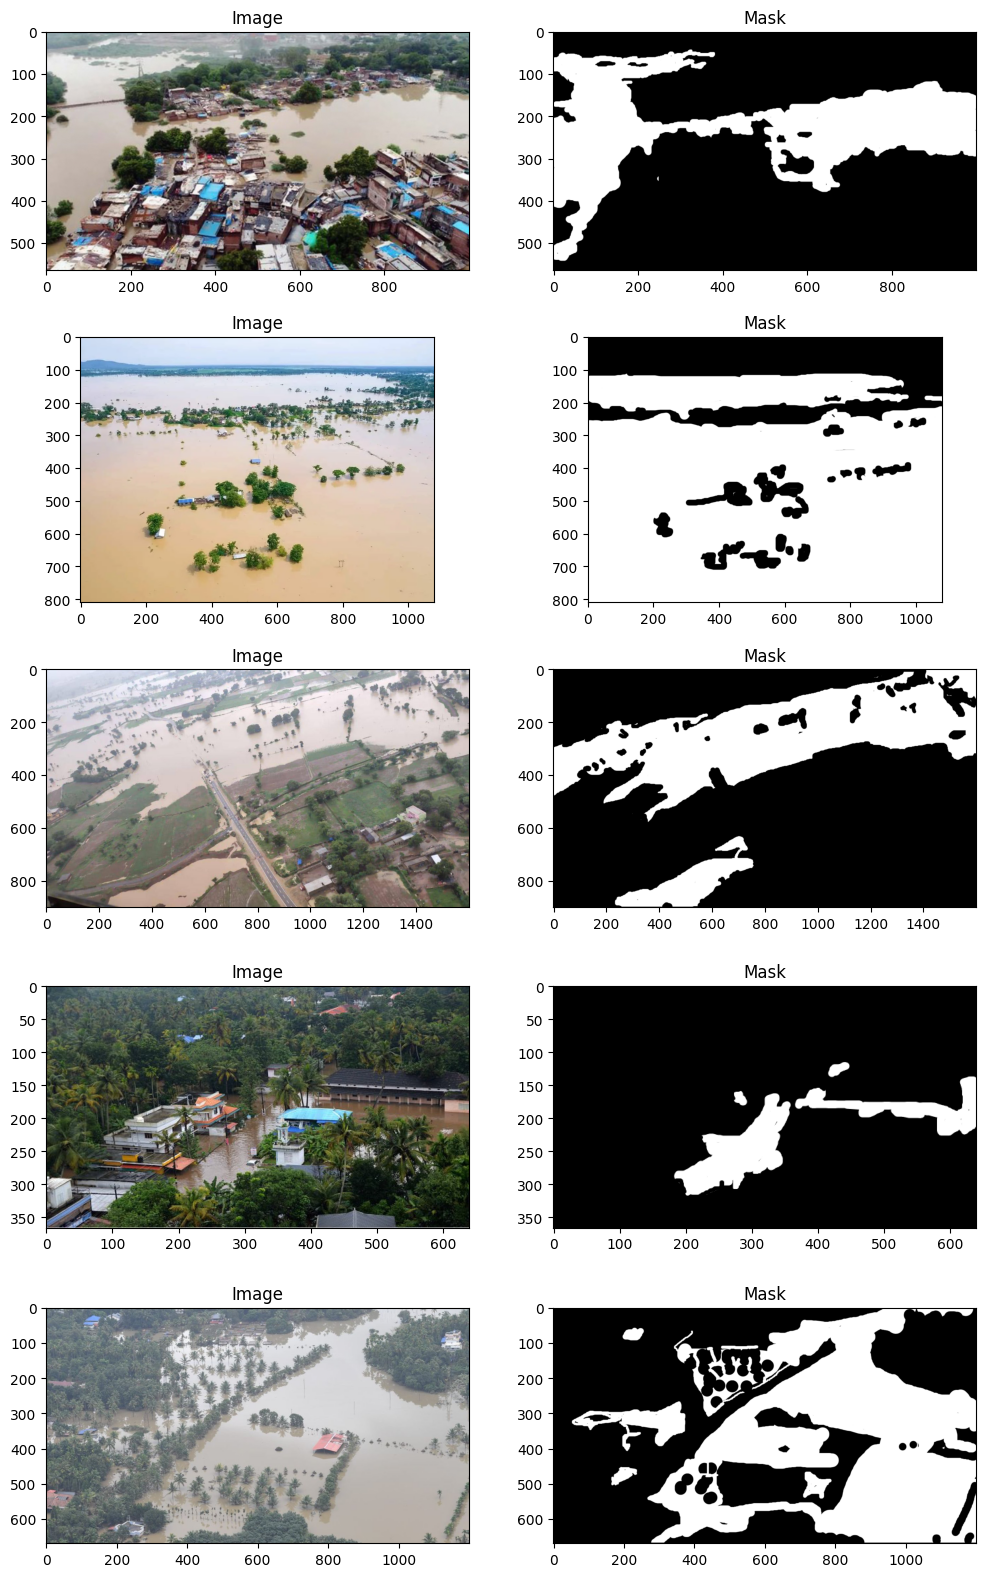

In [12]:
rows = 5
columns = 2
# define subplots figure with 5 rows and 2 columns and its size
ax,figure = plt.subplots(rows,columns,figsize=(12,20))
# we need to get the index of each fugire 
for i in range(1,10,2):
  # random.randint(low,high) is used to get random integer between low and high
  random_number = np.random.randint(0,290)
  # define a subplot which will be at index 1 at ecah row
  plt.subplot(rows,columns,i)
  plt.title("Image")
  plt.imshow(load_img(images[random_number]))
  # define another subplot which will be at index 2 at ecah row
  plt.subplot(rows,columns,i+1)
  plt.title("Mask")
  plt.imshow(load_img(masks[random_number]))


In [13]:
IMG_SIZE = 256

In [14]:
img = Image.open('/content/Image/10.jpg').convert('RGB')
img = np.array(img)
#img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
print(img)
# plt.imshow(img)

[[[233 232 238]
  [231 230 236]
  [230 229 235]
  ...
  [236 235 251]
  [235 234 250]
  [229 228 244]]

 [[231 230 236]
  [229 228 234]
  [230 229 235]
  ...
  [234 233 249]
  [232 231 247]
  [231 230 246]]

 [[228 227 233]
  [228 227 233]
  [230 229 235]
  ...
  [236 236 246]
  [234 234 244]
  [232 232 242]]

 ...

 [[ 57  43  30]
  [ 45  31  18]
  [ 47  26  15]
  ...
  [ 17  12   8]
  [ 21  17  16]
  [ 25  22  20]]

 [[ 53  39  26]
  [ 50  36  23]
  [ 77  62  49]
  ...
  [ 19  13  10]
  [ 14  10   9]
  [ 18  14  13]]

 [[ 66  51  37]
  [ 71  55  42]
  [ 38  28  13]
  ...
  [ 22  18  17]
  [ 21  21  19]
  [ 20  20  18]]]


In [15]:
# define numpy array with shape (290, 256,256,3) and its type is int
# we will use it to save our images
X = np.zeros((len(images),IMG_SIZE,IMG_SIZE,3),dtype=np.float32)
# define numpy array with shape (290, 256,256,3) and its type is boolean
# we will use it to save our masks
Y = np.zeros((len(images),IMG_SIZE,IMG_SIZE),dtype=np.bool_)

In [16]:
def process_image(img,image_type):
  # check the type of image
  if image_type == "image":
    # convert image into numpy array
    img = np.array(img)
    # resize image using cv2.resize , cv2 stand for open cv 2 
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    img = img / 255.0
    
  else:
    # convert image into numpy array
    img = np.array(img)
    # convert mask from RGB to GRAY scale
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
  return img


In [17]:
# loop over images and masks
# `tqdm` is used to show the progress of the function in a progress bar
for i in tqdm(range(len(images))):
  # rean image with its path and convert it to RGB to be able to convert it to numpy array 
  img = Image.open(images[i]).convert('RGB')
  # read mask
  mask = Image.open(masks[i]).convert('RGB')
  # pass image to `process_image` with its type
  img = process_image(img,"image")
  mask = process_image(mask,"mask")
  # put image metrix in X
  X[i] = img
  Y[i] = mask

100%|██████████| 290/290 [00:30<00:00,  9.58it/s]


In [18]:
X[1]

array([[[0.53333336, 0.43529412, 0.30588236],
        [0.6627451 , 0.5019608 , 0.4       ],
        [0.7294118 , 0.47843137, 0.40784314],
        ...,
        [0.34901962, 0.36862746, 0.28235295],
        [0.3764706 , 0.3882353 , 0.3019608 ],
        [0.42745098, 0.43137255, 0.35686275]],

       [[0.45882353, 0.3882353 , 0.26666668],
        [0.5686275 , 0.4509804 , 0.34117648],
        [0.6784314 , 0.48235294, 0.39607844],
        ...,
        [0.35686275, 0.3647059 , 0.28627452],
        [0.3372549 , 0.34901962, 0.26666668],
        [0.40784314, 0.40392157, 0.32156864]],

       [[0.4627451 , 0.42745098, 0.30588236],
        [0.5294118 , 0.4627451 , 0.34117648],
        [0.57254905, 0.43529412, 0.33333334],
        ...,
        [0.3529412 , 0.36078432, 0.2784314 ],
        [0.38431373, 0.39215687, 0.3019608 ],
        [0.3372549 , 0.33333334, 0.24313726]],

       ...,

       [[0.94509804, 0.7372549 , 0.47843137],
        [0.94509804, 0.73333335, 0.47058824],
        [0.94509804, 0

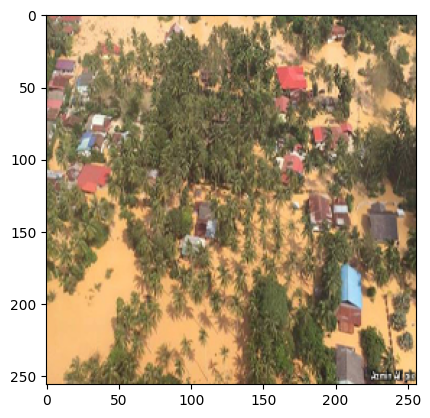

In [19]:
plt.imshow(X[1])

In [20]:
X = tf.convert_to_tensor(X)
Y = tf.convert_to_tensor(Y)

In [21]:
data = tf.data.Dataset.from_tensor_slices((X,Y))

In [22]:
val_size = int(len(images) * 0.15)
train_ds = data.skip(val_size)
val_ds = data.take(val_size)

In [23]:
len(train_ds)

247

In [24]:
BATCH_SIZE = 4
train_ds=train_ds.batch(BATCH_SIZE)
train_ds=train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.batch(BATCH_SIZE)
val_ds=val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Pre-training
In simple terms, pre-training a neural network refers to first training a model on one task or dataset. Then using the parameters or model from this training to train another model on a different task or dataset. This gives the model a head-start instead of starting from scratch.

In [25]:
# load DenseNet121 which is a pretrained model that is trained on `imagenet` dataset which 
# is a large dataset of labeled images.

# `include_top` means that the final fully contected layer of the model which is used for classification 
#will no included this allows us to add our own cutom layers

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE, 3))

29084464/29084464 [==============================] - 0s 0us/step


In [26]:
# add our custom layers
x=Conv2D(1,kernel_size=(1,1), activation="relu", padding="same")(base_model.output)
output=Conv2DTranspose(1,kernel_size=64,activation="sigmoid", strides=32, padding="same" )(x)

In [27]:
# create an instance of model with inputs pretrained model input and output our custom layers
fc_model = Model(inputs=base_model.input,outputs=output)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.690719 to fit



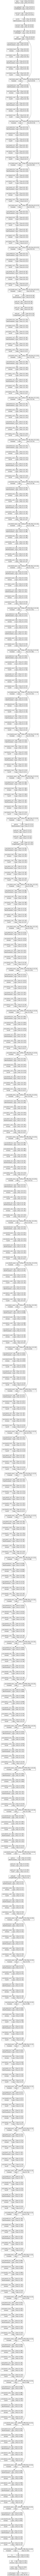

In [28]:
plot_model(fc_model, show_shapes=True)

In [29]:
# create an instance of adam optimizer with learning rate of 0.001 
adam = Adam(learning_rate=0.001)

# configure model with optimizer > adam and binary loss function 
fc_model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [30]:
### CallBacks ###
  # learning Rate decay
  # Check Point

# `file_path` the path where the best model will be saved
# `monitor` the metric that being monitored for save the best model,in this case we use `val_accuracy`
# `mode` when to save the model with maximum or minimun value of monitor
file_path = 'best_model.h5'
cp = ModelCheckpoint(file_path, monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)


# `patience` how many epoch to wait before reducing the learning rate
# `verbose` controls the amount of output during training
# `factor` the factor by which the learning rate will reduce if there is no improvemnt in training
# `min_lr` sets a lower bound of learning Rate
rl_reduce = ReduceLROnPlateau(monitor='val_accuracy',patience=5,factor=.5
                              ,min_lr=1e-6)

history = fc_model.fit(train_ds,epochs=50,validation_data=val_ds,verbose = 1,callbacks=[cp,rl_reduce])

Epoch 1/60
62/62 [==============================] - ETA: 0s - loss: 0.6378 - accuracy: 0.5683
Epoch 1: val_accuracy improved from -inf to 0.56770, saving model to best_model.h5
62/62 [==============================] - 97s 201ms/step - loss: 0.6378 - accuracy: 0.5683 - val_loss: 0.6926 - val_accuracy: 0.5677 - lr: 0.0010
Epoch 2/60
62/62 [==============================] - ETA: 0s - loss: 0.5674 - accuracy: 0.6848
Epoch 2: val_accuracy did not improve from 0.56770
62/62 [==============================] - 6s 90ms/step - loss: 0.5674 - accuracy: 0.6848 - val_loss: 0.6655 - val_accuracy: 0.5668 - lr: 0.0010
Epoch 3/60
62/62 [==============================] - ETA: 0s - loss: 0.5375 - accuracy: 0.7637
Epoch 3: val_accuracy did not improve from 0.56770
62/62 [==============================] - 6s 89ms/step - loss: 0.5375 - accuracy: 0.7637 - val_loss: 0.6907 - val_accuracy: 0.5303 - lr: 0.0010
Epoch 4/60
62/62 [==============================] - ETA: 0s - loss: 0.5217 - accuracy: 0.7845
Epoch 4:

In [31]:
print("Model Performance on Validation Data")
result = fc_model.evaluate(val_ds)
print(dict(zip(fc_model.metrics_names, result)))

Model Performance on Validation Data
11/11 [==============================] - 0s 31ms/step - loss: 0.3939 - accuracy: 0.8512
{'loss': 0.39391687512397766, 'accuracy': 0.8512037396430969}


In [32]:
def plot_graph(history,value):
  # get the data stored in history by value and plot it
  plt.plot(history.history[value],label="Traning "+value)
  plt.plot(history.history['val_'+value],label="Validation "+value)
  # `legend` is an area describing the elements of the graph
  plt.legend()
  # x axis label
  plt.xlabel('Epochs')
  # y axis label
  plt.ylabel(value)
  plt.title(value + " Vs Epochs")
  plt.show()

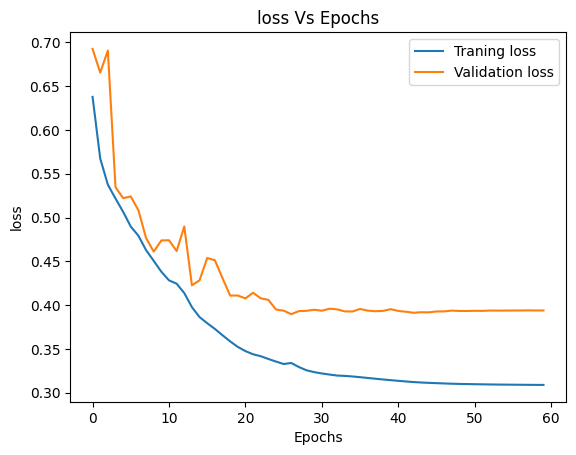

In [33]:
plot_graph(history,'loss')

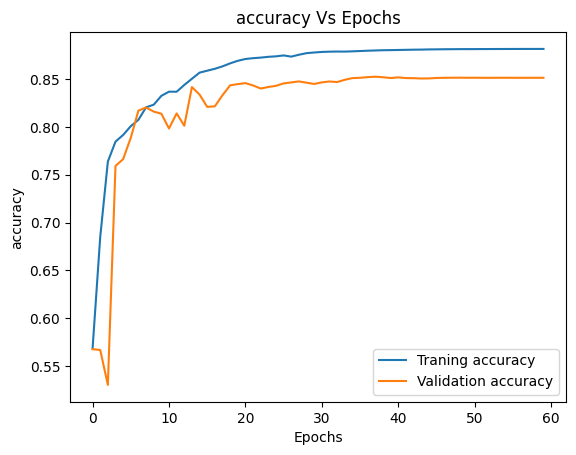

In [34]:
plot_graph(history,'accuracy')

In [39]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_SIZE,IMG_SIZE, 3], include_top=False)
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

9406464/9406464 [==============================] - 0s 0us/step


In [40]:
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack =Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


In [41]:
!git clone https://github.com/tensorflow/examples.git
import sys 
sys.path.append('/content/examples') 

Cloning into 'examples'...
remote: Enumerating objects: 23138, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 23138 (delta 32), reused 75 (delta 23), pack-reused 23038
Receiving objects: 100% (23138/23138), 42.20 MiB | 34.96 MiB/s, done.
Resolving deltas: 100% (12681/12681), done.


In [42]:
from tensorflow_examples.models.pix2pix import pix2pix
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [43]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels,activation="sigmoid", kernel_size=3, strides=2,
      padding='same')  #64x64 -> 256x256

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [44]:
OUTPUT_CLASSES = 1
u_model = unet_model(output_channels=OUTPUT_CLASSES)
u_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

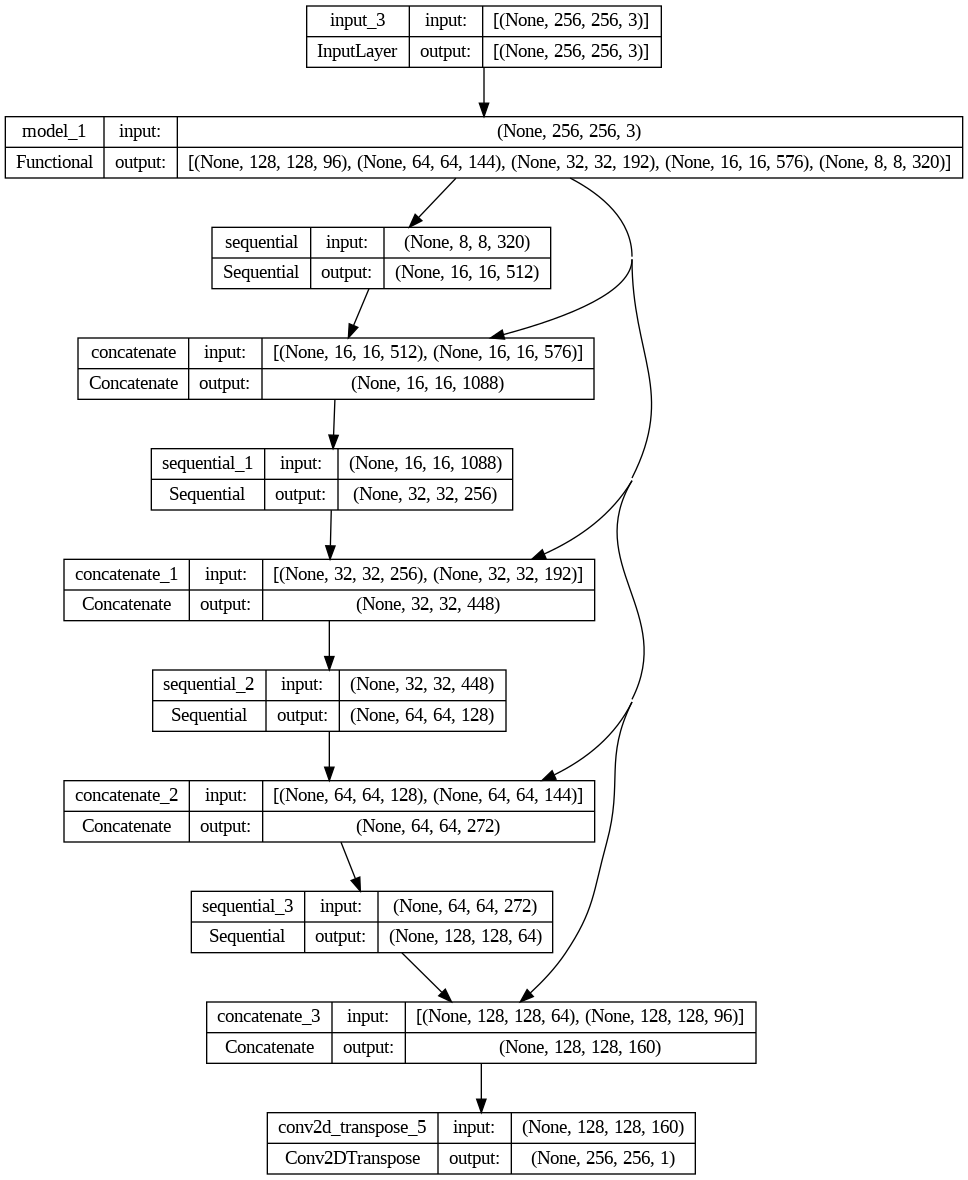

In [45]:
plot_model(u_model, show_shapes=True)

In [46]:
file_path = 'u_model.h5'
cp = ModelCheckpoint(file_path, monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)


rl_reduce = ReduceLROnPlateau(monitor='val_accuracy',patience=5,factor=.5
                              ,min_lr=1e-6)

history = u_model.fit(train_ds,epochs=50,validation_data=val_ds,verbose = 1,callbacks=[cp,rl_reduce])

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 0.4481 - accuracy: 0.7953
Epoch 1: val_accuracy improved from -inf to 0.67860, saving model to u_model.h5
62/62 [==============================] - 12s 74ms/step - loss: 0.4481 - accuracy: 0.7953 - val_loss: 1.1262 - val_accuracy: 0.6786 - lr: 0.0010
Epoch 2/50
61/62 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8589
Epoch 2: val_accuracy improved from 0.67860 to 0.84104, saving model to u_model.h5
62/62 [==============================] - 3s 42ms/step - loss: 0.3404 - accuracy: 0.8594 - val_loss: 0.4762 - val_accuracy: 0.8410 - lr: 0.0010
Epoch 3/50
61/62 [============================>.] - ETA: 0s - loss: 0.3206 - accuracy: 0.8680
Epoch 3: val_accuracy improved from 0.84104 to 0.87209, saving model to u_model.h5
62/62 [==============================] - 3s 41ms/step - loss: 0.3197 - accuracy: 0.8685 - val_loss: 0.3530 - val_accuracy: 0.8721 - lr: 0.0010
Epoch 4/50
61/62 [========================

In [47]:
print("Model Performance on Validation Data")
result = u_model.evaluate(val_ds)
print(dict(zip(u_model.metrics_names, result)))

Model Performance on Validation Data
11/11 [==============================] - 0s 15ms/step - loss: 0.4211 - accuracy: 0.8932
{'loss': 0.42106980085372925, 'accuracy': 0.8932062387466431}


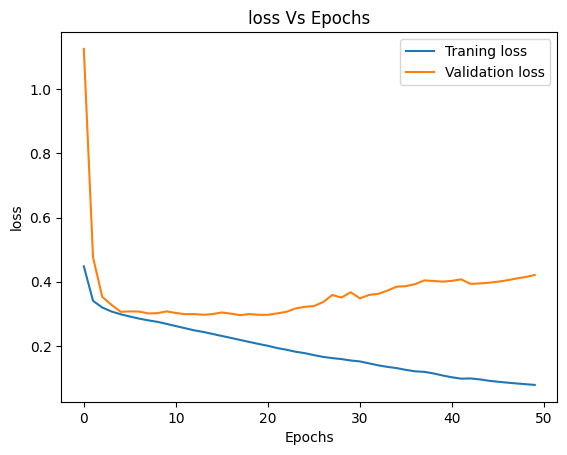

In [48]:
plot_graph(history,'loss')

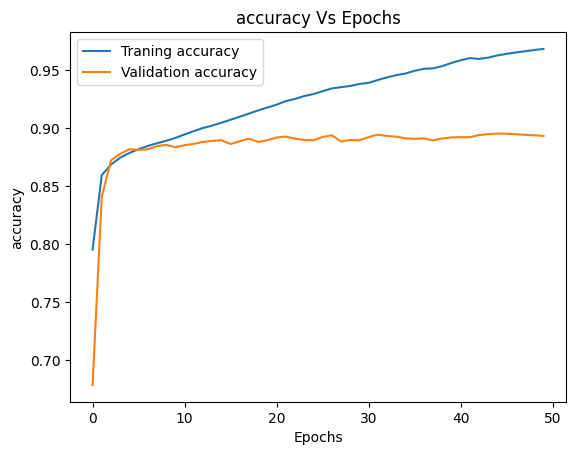

In [49]:
plot_graph(history,'accuracy')

In [79]:
# laod best model that is saved by model check point 
model = load_model('/content/u_model.h5')

1/1 [==============================] - 0s 38ms/step


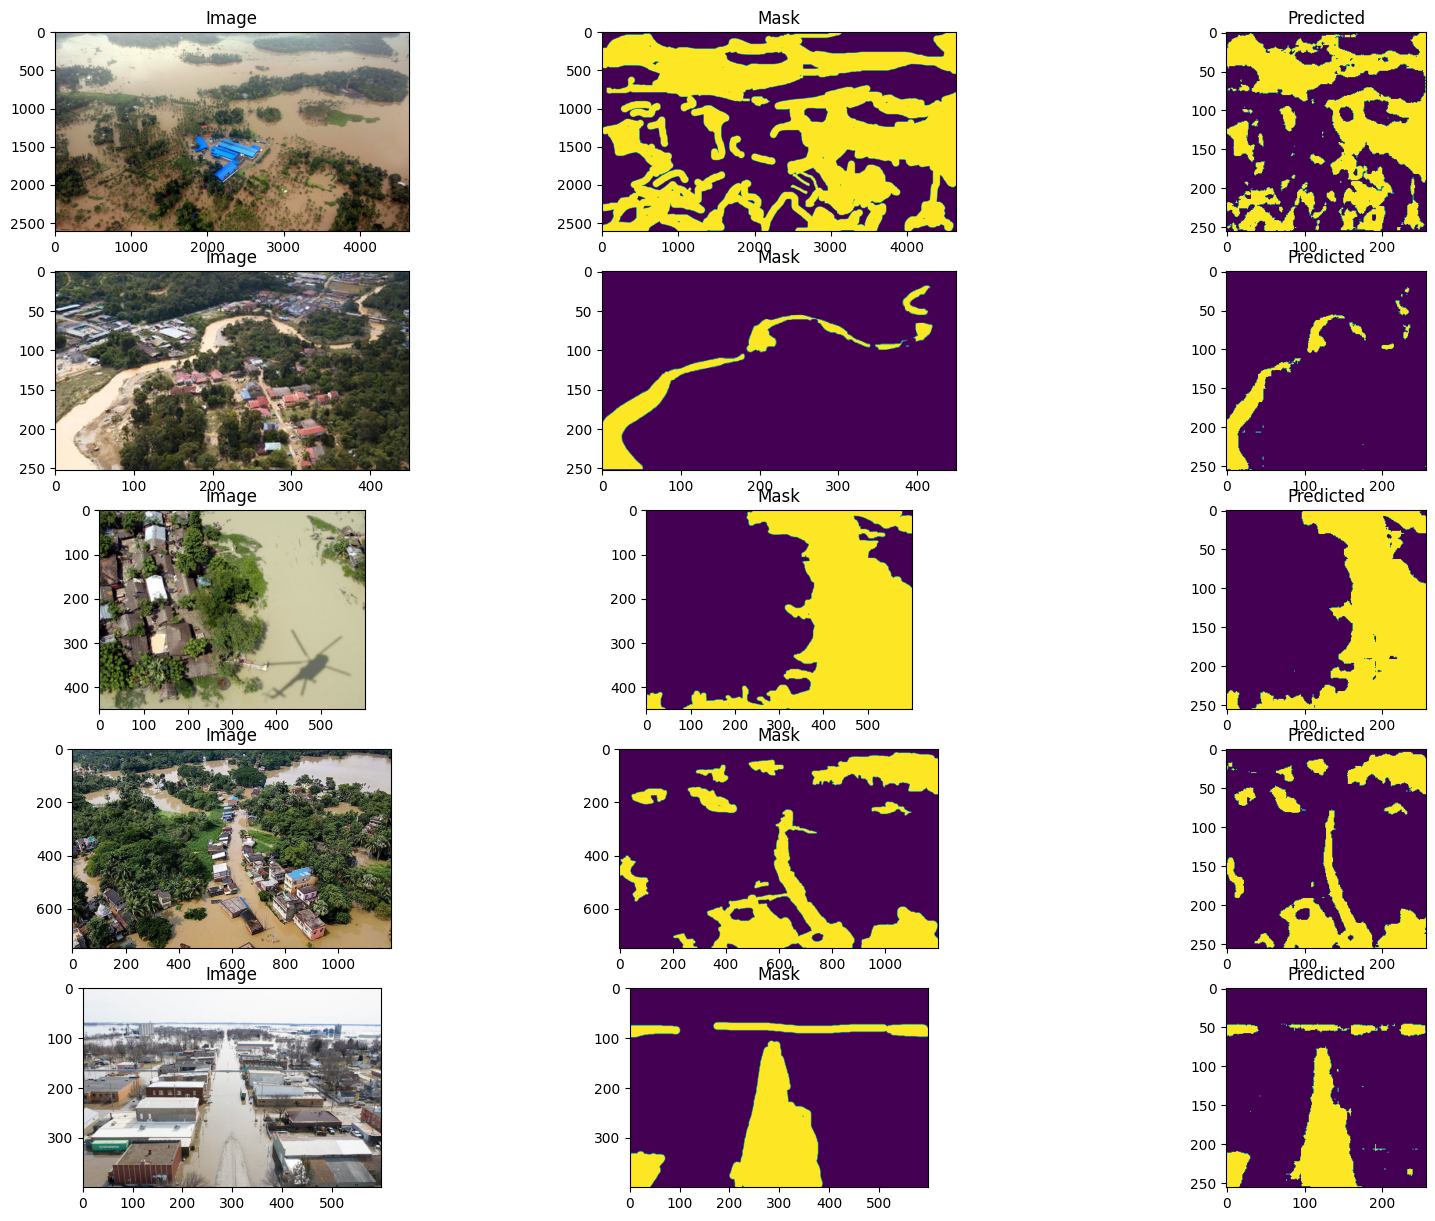

In [83]:
rows = 5
columns = 3
ax,fig = plt.subplots(rows,columns,figsize=(20,15))
for idx in range(1,16,3):
  # randint(low,high) is used to get random number between low and high
  random_number = np.random.randint(0,290)
  # get random image and mask from images list using random_number
  img = images[random_number]
  mask = masks[random_number]

  # read image and convert it to RED GREEB BLUE 
  image = Image.open(img).convert('RGB')
  # read mask
  mask = Image.open(mask)
  
  # process the image with the same procssing of model's input
  img = process_image(image,'image')
  # reshape image to (batch,width,height,channels) 
  img = np.reshape(img,(-1,IMG_SIZE,IMG_SIZE,3))
  # get model prediction 
  predicted = np.round(model.predict(img))
  
  # define subplot with 1 in each row
  plt.subplot(rows,columns,idx)
  # set title 
  plt.title('Image')
  # plot image
  plt.imshow(image)
  # define subplot with 2 in each row
  plt.subplot(rows,columns,idx+1)
  plt.title('Mask')
  plt.imshow(mask)
  # define subplot with 3 in each row
  plt.subplot(rows,columns,idx+2)
  plt.title('Predicted')
  plt.imshow(predicted.reshape(IMG_SIZE,IMG_SIZE))
plt.show()
